# Imports
<div style="width:100%;border-bottom: 3px solid #F03A4F;margin-bottom: 1rem;"></div>

In [2]:
!pip install ultralytics -q
!pip install -U ultralytics
!pip install numpy
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.6/913.6 kB 38.0 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO
from ultralytics.data.dataset import YOLODataset

import ultralytics.data.build as build
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from ultralytics import YOLO  # Import the YOLO framework


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# To import the stored dataset any time
<div style="width:100%;border-bottom: 3px solid #F27B40;margin-bottom: 1rem;"></div>

In [49]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:

import os
from pathlib import Path

x_train = []
y_train = []
x_test = []
y_test = []

train_image_dir = Path('/content/drive/MyDrive/Car_Dent_Scratch_Detection-/train/images')
train_label_dir = Path('/content/drive/MyDrive/Car_Dent_Scratch_Detection-/train/labels')
test_image_dir = Path('/content/drive/MyDrive/Car_Dent_Scratch_Detection-/test/images')
test_label_dir = Path('/content/drive/MyDrive/Car_Dent_Scratch_Detection-/test/labels')


for filename in os.listdir(train_image_dir):
  if filename.endswith('.jpg'):
    img_path = os.path.join(train_image_dir, filename)
    label_filename = filename[:-4] + '.txt'
    label_path = os.path.join(train_label_dir, label_filename)
    # assuming you want to load images as numpy arrays (e.g., using cv2)
    # you can adjust this to your preferred image loading method
    x_train.append(img_path)
    y_train.append(label_path)


for filename in os.listdir(test_image_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(test_image_dir, filename)
        label_filename = filename[:-4] + '.txt'
        label_path = os.path.join(test_label_dir, label_filename)
        x_test.append(img_path)
        y_test.append(label_path)


print(f"Number of training images: {len(x_train)}")
print(f"Number of training labels: {len(y_train)}")
print(f"Number of test images: {len(x_test)}")
print(f"Number of test labels: {len(y_test)}")


Number of training images: 1810
Number of training labels: 1810
Number of test images: 615
Number of test labels: 615


# To Balance the weight Using Weighted Dataloader
<div style="width:100%;border-bottom: 3px solid #F27B40;margin-bottom: 1rem;"></div>

# Weighted Dataloader

In [5]:
class YOLOWeightedDataset(YOLODataset):
    def __init__(self, *args, mode="train", **kwargs):
        """
        Initialize the WeightedDataset.

        Args:
            class_weights (list or numpy array): A list or array of weights corresponding to each class.
        """

        super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

        self.train_mode = "train" in self.prefix

        # You can also specify weights manually instead
        self.count_instances()
        class_weights = np.sum(self.counts) / self.counts
        self.agg_func = np.mean

        self.class_weights = np.array(class_weights)
        self.weights = self.calculate_weights()
        self.probabilities = self.calculate_probabilities()

    def count_instances(self):
        """
        Count the number of instances per class

        Returns:
            dict: A dict containing the counts for each class.
        """
        self.counts = [0 for i in range(len(self.data["names"]))]
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)
            for id in cls:
                self.counts[id] += 1

        self.counts = np.array(self.counts)
        self.counts = np.where(self.counts == 0, 1, self.counts)

    def calculate_weights(self):
        """
        Calculate the aggregated weight for each label based on class weights.

        Returns:
            list: A list of aggregated weights corresponding to each label.
        """
        weights = []
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)

            # Give a default weight to background class
            if cls.size == 0:
              weights.append(1)
              continue

            # Take mean of weights
            # You can change this weight aggregation function to aggregate weights differently
            # weight = np.mean(self.class_weights[cls])
            # weight = np.max(self.class_weights[cls])
            weight = self.agg_func(self.class_weights[cls])
            weights.append(weight)
        return weights

    def calculate_probabilities(self):
        """
        Calculate and store the sampling probabilities based on the weights.

        Returns:
            list: A list of sampling probabilities corresponding to each label.
        """
        total_weight = sum(self.weights)
        probabilities = [w / total_weight for w in self.weights]
        return probabilities

    def __getitem__(self, index):
        """
        Return transformed label information based on the sampled index.
        """
        # Don't use for validation
        if not self.train_mode:
            return self.transforms(self.get_image_and_label(index))
        else:
            index = np.random.choice(len(self.labels), p=self.probabilities)
            return self.transforms(self.get_image_and_label(index))

In [6]:
# Monkey patch method
build.YOLODataset = YOLOWeightedDataset

# Train without weighted dataloader

In [ ]:
# Revert to old class
build.YOLODataset = YOLODataset

In [ ]:
model = YOLO("yolo11n.pt")

In [ ]:
results = model.train(data="/content/drive/MyDrive/Car_Dent_Scratch_Detection-/data.yaml", epochs=5 , patience=3, batch=16, imgsz=640, optimizer='Adam', hsv_v=0.7, degrees=0.0, box=6.5, cls=0.3, dropout=0.20, lr0=0.001)

In [ ]:
# Verify the type of dataset used
model.trainer.train_loader.dataset

In [ ]:
img = cv2.imread("runs/detect/train/train_batch1.jpg")[...,::-1]

In [ ]:
# Training plots will be unbalanced
plt.imshow(img)

# Train with weighted dataloader

In [7]:
# Monkey patch method to use weighted dataloader
build.YOLODataset = YOLOWeightedDataset

In [ ]:
#the trainig and validating process was done in a pc device

model = YOLO('yolo11n.pt')  # Specify the config file

# Training script
results_train = model.train(
    data="/content/drive/MyDrive/Car_Dent_Scratch_Detection-/data.yaml",
    epochs=1000,
    batch=32,
    imgsz=640,
    optimizer='Adam',
    box=7.5,
    cls=0.4,
    dropout=0.15,
    hsv_v=0.7,
    degrees=0.3,
    lr0=0.001,
    workers=32
)
print(results_train)


In [ ]:
# Evaluate the trained model
results_val = model.val(split='test')
print(f"Results: {results_val}")

In [ ]:
# Verify the type of dataset used. It should say
# YOLOWeightedDataset
model.trainer.train_loader.dataset

In [39]:
#predict with a sample image
results = model.predict("/content/drive/MyDrive/Car_Dent_Scratch_Detection-/test/images/0184_jpeg.rf.f3676162c8b3799e1f997a1feb4832b9.jpg", save=True, imgsz=320, conf=0.5)  # return a list of results objects
#process results list
for result in results:
    boxes = result.boxes
    masks = result.masks
    keypoints = result.keypoints
    probs = result.probs
    obb = result.obb
    result.save(filename="result.jpg")



image 1/1 /content/drive/MyDrive/Car_Dent_Scratch_Detection-1--2/test/images/0184_jpeg.rf.f3676162c8b3799e1f997a1feb4832b9.jpg: 320x320 1 bonnet-dent, 1 front-bumper-dent, 13.3ms
Speed: 1.8ms preprocess, 13.3ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 320)
Results saved to runs/detect/train65


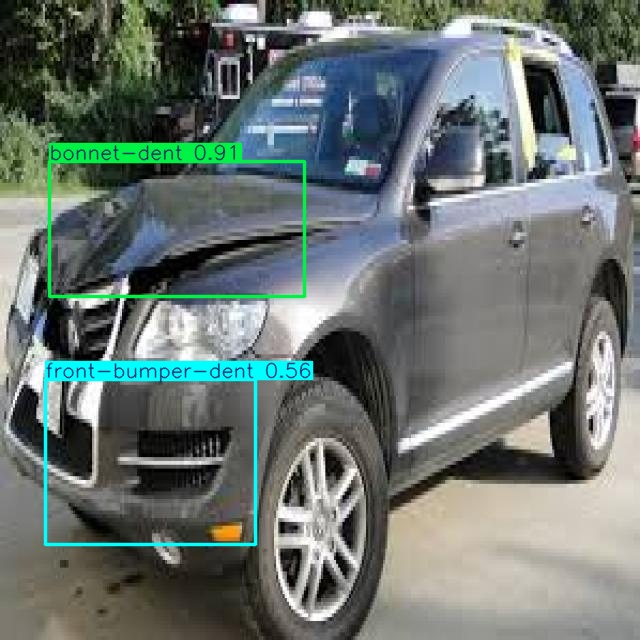

In [38]:

from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import numpy as np
#just to see the result
img = cv2.imread('/content/result.jpg')


cv2_imshow(img)

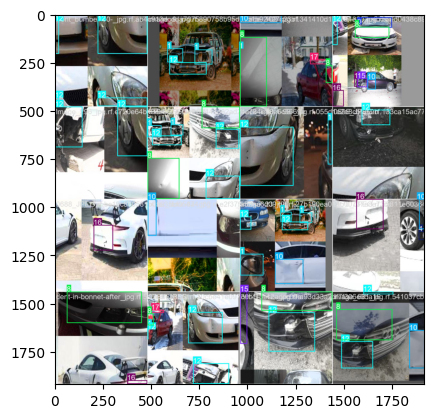

In [34]:
img = cv2.imread("/content/final/train_batch0.jpg")[...,::-1]
# Training plots will be balanced
plt.imshow(img)

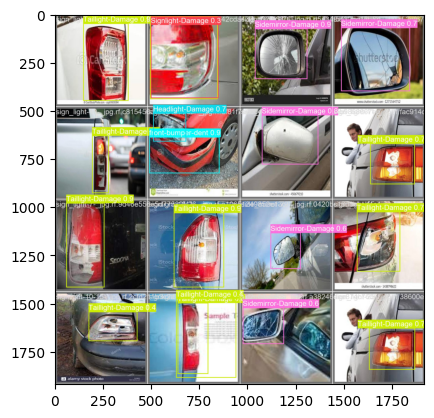

In [42]:
img = cv2.imread("/content/final/val_batch0_pred.jpg")[...,::-1]
plt.imshow(img)

# Detection Results
<div style="width:100%;border-bottom: 3px solid #F27B40;margin-bottom: 1rem;"></div>

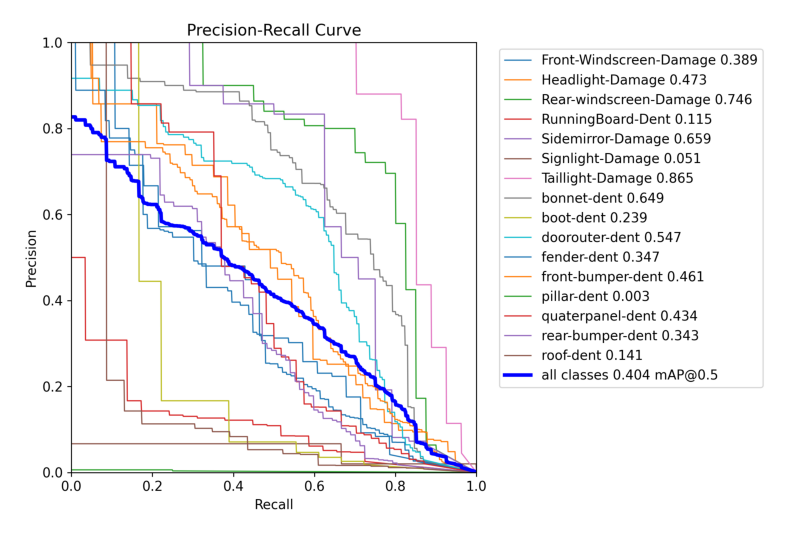

In [35]:
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(10,20))
plt.imshow(Image.open('/content/final/PR_curve.png'))
plt.axis('off')
plt.show()

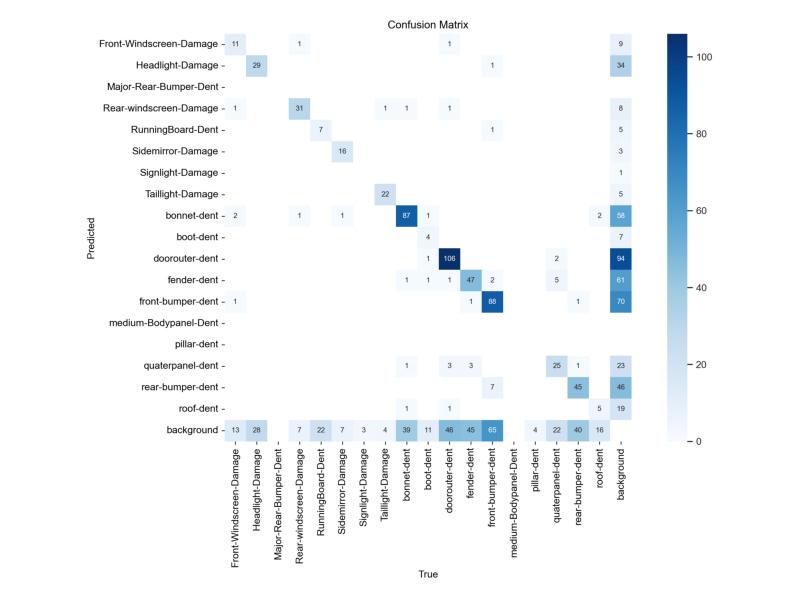

In [36]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/content/final/confusion_matrix.png'))
plt.axis('off')
plt.show()

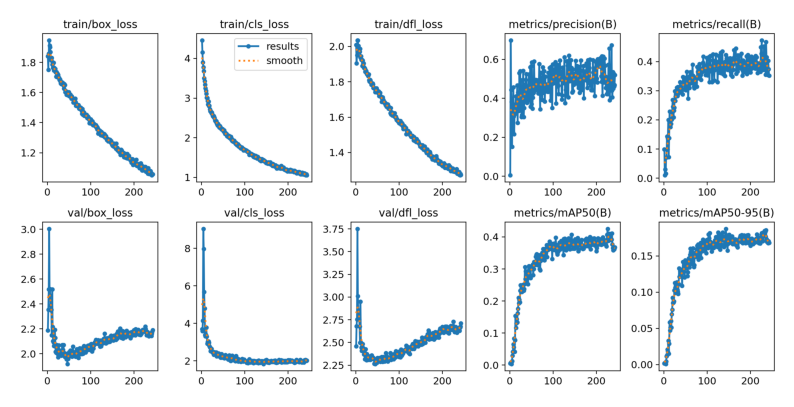

In [41]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/content/final/results.png'))
plt.axis('off')
plt.show()

# K-Fold Cross Validation
<div style="width:100%;border-bottom: 3px solid #F27B40;margin-bottom: 1rem;"></div>

In [58]:
from sklearn.model_selection import KFold
from ultralytics import YOLO
from numpy import mean
import numpy as np

def k_fold_cross_validation(model, data_yaml, k=5, epochs=5):
    kf = KFold(n_splits=k, shuffle=True)

    fold_results = []

    for fold in range(k):
        print(f"Fold {fold + 1}/{k}")



        model.train(data=data_yaml, epochs=epochs, batch=32,optimizer='SGD',cls=0.8,visualize=True, lr0= 0.01)

        # Validate after each fold and take results
        results = model.val(data=data_yaml)
        fold_results.append(results.box.map)
        print('full results ', results )
        print("Mean Average Precision:", results.box.map)
        print("Mean Average Precision at IoU=0.50:", results.box.map50)
        print("Mean Average Precision at IoU=0.75:", results.box.map75)
        print("Mean Average Precision for different IoU thresholds:", results.box.maps)
        print('accuracy:',results.box.p)
    print("Mean Average Precision (mAP) across folds:", np.mean(fold_results))
    print("Mean Average Precision:", results.box.map)
    print("Mean Average Precision at IoU=0.50:", results.box.map50)
    print("Mean Average Precision at IoU=0.75:", results.box.map75)
    print("Mean Average Precision for different IoU thresholds:", results.box.maps)
    print('accuracy:',results.box.p)

model = YOLO("yolo11n.pt")
model.info()#this is the model.summary in yolo

#call k-fold cross-validation using my data.yaml with k=5
k_fold_cross_validation(model, "/content/drive/MyDrive/Car_Dent_Scratch_Detection-/data.yaml", k=5, epochs=5)

YOLO11n summary: 319 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs
Fold 1/5
New https://pypi.org/project/ultralytics/8.3.69 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/Car_Dent_Scratch_Detection-/data.yaml, epochs=5, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffe

train: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/train/labels.cache... 1810 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1810/1810 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/valid/labels.cache... 614 images, 0 backgrounds, 0 corrupt: 100%|██████████| 614/614 [00:00<?, ?it/s]


Plotting labels to runs/detect/train11/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train11
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.54G      1.771      7.061      1.966         56        640: 100%|██████████| 57/57 [00:10<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


                   all        614        943     0.0121      0.239     0.0315     0.0115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.52G      1.664       6.53      1.842         62        640: 100%|██████████| 57/57 [00:09<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


                   all        614        943      0.488     0.0612     0.0452     0.0178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.52G      1.728      5.955      1.864         68        640: 100%|██████████| 57/57 [00:09<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


                   all        614        943      0.634     0.0541      0.055     0.0256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       5.5G      1.712      5.523      1.867         57        640: 100%|██████████| 57/57 [00:09<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


                   all        614        943      0.306      0.148     0.0857     0.0377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      5.47G      1.647       5.16      1.809         54        640: 100%|██████████| 57/57 [00:09<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


                   all        614        943      0.335      0.233      0.198      0.092

5 epochs completed in 0.021 hours.
Optimizer stripped from runs/detect/train11/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train11/weights/best.pt, 5.5MB

Validating runs/detect/train11/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11n summary (fused): 238 layers, 2,585,662 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


                   all        614        943      0.334      0.232      0.198     0.0922
Front-Windscreen-Damage         27         28      0.174       0.25      0.101     0.0467
      Headlight-Damage         54         57      0.411      0.171      0.195     0.0841
Rear-windscreen-Damage         39         40      0.351       0.65      0.513       0.28
     RunningBoard-Dent         23         29          1          0     0.0834     0.0142
     Sidemirror-Damage         24         24      0.518      0.542      0.555      0.324
      Signlight-Damage          3          3          0          0          0          0
      Taillight-Damage         27         27      0.505      0.778       0.65      0.284
           bonnet-dent        128        130      0.292        0.4      0.267      0.125
             boot-dent         18         18          0          0    0.00651    0.00199
        doorouter-dent        121        159      0.397      0.371      0.342      0.157
           fender-de

val: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/valid/labels.cache... 614 images, 0 backgrounds, 0 corrupt: 100%|██████████| 614/614 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


                   all        614        943      0.334      0.233      0.198     0.0922
Front-Windscreen-Damage         27         28      0.174       0.25        0.1     0.0467
      Headlight-Damage         54         57        0.4      0.175      0.192     0.0829
Rear-windscreen-Damage         39         40      0.345       0.65       0.51      0.279
     RunningBoard-Dent         23         29          1          0     0.0833     0.0141
     Sidemirror-Damage         24         24      0.518      0.542      0.554      0.324
      Signlight-Damage          3          3          0          0          0          0
      Taillight-Damage         27         27      0.503      0.778      0.652      0.284
           bonnet-dent        128        130      0.292        0.4      0.267      0.126
             boot-dent         18         18          0          0    0.00646    0.00196
        doorouter-dent        121        159      0.401      0.377      0.342      0.157
           fender-de

train: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/train/labels.cache... 1810 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1810/1810 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/valid/labels.cache... 614 images, 0 backgrounds, 0 corrupt: 100%|██████████| 614/614 [00:00<?, ?it/s]


Plotting labels to runs/detect/train113/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train113
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.54G      2.849      6.572      2.764         56        640: 100%|██████████| 57/57 [00:10<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        614        943      0.508     0.0737      0.048     0.0185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.52G      2.232      5.616      2.321         62        640: 100%|██████████| 57/57 [00:10<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


                   all        614        943      0.348       0.14      0.115     0.0495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.53G      2.006       5.19      2.116         68        640: 100%|██████████| 57/57 [00:09<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


                   all        614        943      0.214      0.208      0.139     0.0608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.49G      1.858      4.904      2.008         57        640: 100%|██████████| 57/57 [00:09<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        614        943      0.288      0.199      0.159     0.0697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      5.48G       1.78       4.72      1.941         54        640: 100%|██████████| 57/57 [00:09<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


                   all        614        943      0.289      0.261      0.218      0.101

5 epochs completed in 0.021 hours.
Optimizer stripped from runs/detect/train113/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train113/weights/best.pt, 5.5MB

Validating runs/detect/train113/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11n summary (fused): 238 layers, 2,585,662 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


                   all        614        943      0.288      0.264      0.217      0.101
Front-Windscreen-Damage         27         28      0.181      0.284      0.112     0.0519
      Headlight-Damage         54         57      0.346      0.193      0.244      0.113
Rear-windscreen-Damage         39         40        0.4      0.675      0.504      0.291
     RunningBoard-Dent         23         29     0.0621     0.0345     0.0549     0.0172
     Sidemirror-Damage         24         24      0.362      0.521      0.498      0.315
      Signlight-Damage          3          3          0          0          0          0
      Taillight-Damage         27         27       0.45      0.741      0.718      0.335
           bonnet-dent        128        130      0.455      0.477      0.376      0.147
             boot-dent         18         18          0          0    0.00913    0.00249
        doorouter-dent        121        159       0.38      0.465      0.388      0.163
           fender-de

val: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/valid/labels.cache... 614 images, 0 backgrounds, 0 corrupt: 100%|██████████| 614/614 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


                   all        614        943      0.289      0.261      0.218      0.101
Front-Windscreen-Damage         27         28      0.169      0.262      0.112     0.0519
      Headlight-Damage         54         57      0.348      0.193      0.244      0.113
Rear-windscreen-Damage         39         40      0.401      0.675      0.504      0.289
     RunningBoard-Dent         23         29     0.0626     0.0345     0.0548     0.0173
     Sidemirror-Damage         24         24      0.358        0.5        0.5      0.316
      Signlight-Damage          3          3          0          0          0          0
      Taillight-Damage         27         27      0.452      0.741       0.72      0.336
           bonnet-dent        128        130      0.458      0.474      0.375      0.147
             boot-dent         18         18          0          0    0.00913    0.00252
        doorouter-dent        121        159      0.385      0.465      0.388      0.163
           fender-de

train: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/train/labels.cache... 1810 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1810/1810 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/valid/labels.cache... 614 images, 0 backgrounds, 0 corrupt: 100%|██████████| 614/614 [00:00<?, ?it/s]


Plotting labels to runs/detect/train1133/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train1133
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.56G      1.843       4.69      1.992         56        640: 100%|██████████| 57/57 [00:10<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


                   all        614        943      0.287      0.235      0.202     0.0908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.53G      1.753      4.462      1.921         62        640: 100%|██████████| 57/57 [00:10<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


                   all        614        943       0.29      0.268      0.224     0.0993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.52G      1.711      4.287      1.874         68        640: 100%|██████████| 57/57 [00:09<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        614        943      0.342      0.237        0.2     0.0924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.52G      1.666      4.149      1.839         57        640: 100%|██████████| 57/57 [00:09<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


                   all        614        943      0.227      0.272      0.218     0.0928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      5.51G      1.652      4.105      1.822         54        640: 100%|██████████| 57/57 [00:09<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        614        943      0.248      0.261      0.234      0.109

5 epochs completed in 0.021 hours.
Optimizer stripped from runs/detect/train1133/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train1133/weights/best.pt, 5.5MB

Validating runs/detect/train1133/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11n summary (fused): 238 layers, 2,585,662 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


                   all        614        943      0.247      0.263      0.234      0.109
Front-Windscreen-Damage         27         28       0.21      0.286       0.16     0.0729
      Headlight-Damage         54         57      0.237       0.18      0.252      0.107
Rear-windscreen-Damage         39         40      0.574      0.625      0.553       0.33
     RunningBoard-Dent         23         29       0.11      0.172     0.0645     0.0198
     Sidemirror-Damage         24         24      0.351      0.583      0.466      0.286
      Signlight-Damage          3          3          0          0          0          0
      Taillight-Damage         27         27      0.385       0.65      0.609      0.301
           bonnet-dent        128        130       0.48        0.5      0.492      0.213
             boot-dent         18         18          0          0     0.0162     0.0056
        doorouter-dent        121        159      0.425      0.516      0.447      0.189
           fender-de

val: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/valid/labels.cache... 614 images, 0 backgrounds, 0 corrupt: 100%|██████████| 614/614 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]


                   all        614        943      0.247      0.265      0.234      0.109
Front-Windscreen-Damage         27         28      0.205      0.286       0.16     0.0728
      Headlight-Damage         54         57      0.244      0.186      0.255      0.109
Rear-windscreen-Damage         39         40      0.572      0.625      0.553       0.33
     RunningBoard-Dent         23         29      0.108      0.172     0.0643     0.0199
     Sidemirror-Damage         24         24      0.347      0.583      0.465      0.286
      Signlight-Damage          3          3          0          0          0          0
      Taillight-Damage         27         27      0.387      0.667      0.609      0.301
           bonnet-dent        128        130      0.472        0.5      0.491      0.212
             boot-dent         18         18          0          0     0.0162    0.00546
        doorouter-dent        121        159      0.424      0.516      0.448      0.189
           fender-de

train: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/train/labels.cache... 1810 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1810/1810 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/valid/labels.cache... 614 images, 0 backgrounds, 0 corrupt: 100%|██████████| 614/614 [00:00<?, ?it/s]


Plotting labels to runs/detect/train11333/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train11333
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.54G      1.689      4.131      1.859         56        640: 100%|██████████| 57/57 [00:10<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


                   all        614        943      0.231      0.271      0.228      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.53G       1.58      3.812      1.779         62        640: 100%|██████████| 57/57 [00:10<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


                   all        614        943      0.269      0.305      0.249      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.53G      1.523      3.607      1.723         68        640: 100%|██████████| 57/57 [00:09<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


                   all        614        943      0.245      0.264      0.214     0.0971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.52G      1.535      3.641      1.735         57        640: 100%|██████████| 57/57 [00:09<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


                   all        614        943      0.248      0.275      0.236      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      5.49G      1.588      3.787      1.769         54        640: 100%|██████████| 57/57 [00:09<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


                   all        614        943      0.244      0.289      0.247      0.119

5 epochs completed in 0.021 hours.
Optimizer stripped from runs/detect/train11333/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train11333/weights/best.pt, 5.5MB

Validating runs/detect/train11333/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11n summary (fused): 238 layers, 2,585,662 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


                   all        614        943      0.244      0.288      0.246      0.118
Front-Windscreen-Damage         27         28      0.197      0.214      0.172     0.0868
      Headlight-Damage         54         57        0.3      0.193      0.236      0.108
Rear-windscreen-Damage         39         40      0.531        0.7      0.603      0.367
     RunningBoard-Dent         23         29     0.0808      0.207     0.0856     0.0224
     Sidemirror-Damage         24         24      0.329      0.583      0.482      0.282
      Signlight-Damage          3          3          0          0    0.00131   0.000131
      Taillight-Damage         27         27      0.449       0.63       0.63      0.325
           bonnet-dent        128        130      0.411      0.492      0.472      0.215
             boot-dent         18         18          0          0     0.0155    0.00569
        doorouter-dent        121        159      0.438      0.478      0.434      0.187
           fender-de

val: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/valid/labels.cache... 614 images, 0 backgrounds, 0 corrupt: 100%|██████████| 614/614 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]


                   all        614        943      0.244      0.291      0.247      0.119
Front-Windscreen-Damage         27         28      0.196      0.214      0.172      0.087
      Headlight-Damage         54         57      0.298      0.193      0.237      0.109
Rear-windscreen-Damage         39         40      0.529        0.7      0.603      0.367
     RunningBoard-Dent         23         29      0.094      0.241     0.0928     0.0239
     Sidemirror-Damage         24         24      0.329      0.583      0.482      0.287
      Signlight-Damage          3          3          0          0    0.00131   0.000131
      Taillight-Damage         27         27      0.449       0.63      0.631      0.325
           bonnet-dent        128        130      0.409      0.492      0.472      0.215
             boot-dent         18         18          0          0     0.0155    0.00569
        doorouter-dent        121        159      0.437      0.478      0.433      0.186
           fender-de

train: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/train/labels.cache... 1810 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1810/1810 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/valid/labels.cache... 614 images, 0 backgrounds, 0 corrupt: 100%|██████████| 614/614 [00:00<?, ?it/s]


Plotting labels to runs/detect/train113333/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train113333
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.54G      1.611      3.785      1.791         56        640: 100%|██████████| 57/57 [00:10<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


                   all        614        943      0.249      0.292      0.238      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.53G      1.459      3.365      1.682         62        640: 100%|██████████| 57/57 [00:09<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


                   all        614        943      0.272      0.297      0.239      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.52G      1.383      3.106      1.611         68        640: 100%|██████████| 57/57 [00:09<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        614        943      0.244      0.277      0.207     0.0963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.52G      1.427      3.282      1.653         57        640: 100%|██████████| 57/57 [00:09<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


                   all        614        943      0.245      0.286      0.224        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      5.51G      1.548      3.578      1.732         54        640: 100%|██████████| 57/57 [00:09<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


                   all        614        943      0.251      0.361      0.252      0.121

5 epochs completed in 0.021 hours.
Optimizer stripped from runs/detect/train113333/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train113333/weights/best.pt, 5.5MB

Validating runs/detect/train113333/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11n summary (fused): 238 layers, 2,585,662 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


                   all        614        943      0.251      0.359      0.252      0.121
Front-Windscreen-Damage         27         28      0.198      0.321      0.224      0.124
      Headlight-Damage         54         57      0.291      0.263      0.217        0.1
Rear-windscreen-Damage         39         40      0.556      0.725      0.609      0.373
     RunningBoard-Dent         23         29     0.0754      0.345      0.087     0.0237
     Sidemirror-Damage         24         24      0.305      0.548      0.469      0.273
      Signlight-Damage          3          3          0          0   0.000833   0.000333
      Taillight-Damage         27         27      0.454      0.667      0.634      0.315
           bonnet-dent        128        130      0.408      0.523      0.472      0.224
             boot-dent         18         18     0.0873      0.111     0.0325     0.0115
        doorouter-dent        121        159      0.389      0.566       0.41       0.17
           fender-de

val: Scanning /content/drive/.shortcut-targets-by-id/1dBCYrFf79x40qJwfPSA89yoP7lRE6cCS/Car_Dent_Scratch_Detection-1--2-2/valid/labels.cache... 614 images, 0 backgrounds, 0 corrupt: 100%|██████████| 614/614 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]


                   all        614        943      0.251      0.359      0.252      0.121
Front-Windscreen-Damage         27         28      0.199      0.321      0.224      0.124
      Headlight-Damage         54         57      0.291      0.263      0.217        0.1
Rear-windscreen-Damage         39         40      0.555      0.725      0.609      0.376
     RunningBoard-Dent         23         29     0.0759      0.345     0.0906     0.0239
     Sidemirror-Damage         24         24      0.305      0.548      0.469      0.274
      Signlight-Damage          3          3          0          0   0.000828   0.000248
      Taillight-Damage         27         27      0.454      0.667      0.634      0.315
           bonnet-dent        128        130      0.411      0.523      0.473      0.222
             boot-dent         18         18     0.0873      0.111     0.0325     0.0118
        doorouter-dent        121        159       0.39      0.567       0.41       0.17
           fender-de

In [ ]:
model.info()

YOLO11n summary (fused): 238 layers, 2,585,662 parameters, 0 gradients, 6.3 GFLOPs


(238, 2585662, 0, 6.3312896)

# Check class balance

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def verify_class_balance(dataset, num_samples=1000):
    """
    Verifies whether the __getitem__ method in the YOLOWeightedDataset class returns a balanced class output.

    Args:
        dataset: An instance of YOLOWeightedDataset.
        num_samples: Number of samples to draw from the dataset.

    Returns:
        class_counts: A dictionary containing the class counts.
    """
    all_labels = []

    if dataset.train_mode:
        choices = np.random.choice(len(dataset.labels), size=num_samples, p=dataset.probabilities)
    else:
        choices = range(len(dataset.labels))

    for i in choices:
        label = dataset.labels[i]["cls"]
        all_labels.extend(label.reshape(-1).astype(int))

    class_counts = Counter(all_labels)
    return class_counts

def plot_class_balance(weighted_cnts, unweighted_cnts, class_names):
    """
    Plots the comparison of class distribution between training and validation modes.

    Args:
        weighted_cnts: A dictionary containing the class counts in weighted mode.
        unweighted_cnts: A dictionary containing the class counts in unweighted mode.
        class_names: A list of class names.
    """
    classes = range(len(class_names))
    weighted_values = [weighted_cnts.get(c, 0) for c in classes]
    unweighted_values = [unweighted_cnts.get(c, 0) for c in classes]

    width = 0.35  # Bar width

    fig, ax = plt.subplots()
    ax.bar(classes, unweighted_values, width, label='Normal mode', color='#ADD8E6')  # Light blue
    ax.bar([c + width for c in classes], weighted_values, width, label='Weighted Mode', color='#6495ED')  # Medium blue

    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title('Class Distribution in Normal vs Weighted Modes')
    ax.set_xticks([c + width / 2 for c in classes])
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()

    plt.show()

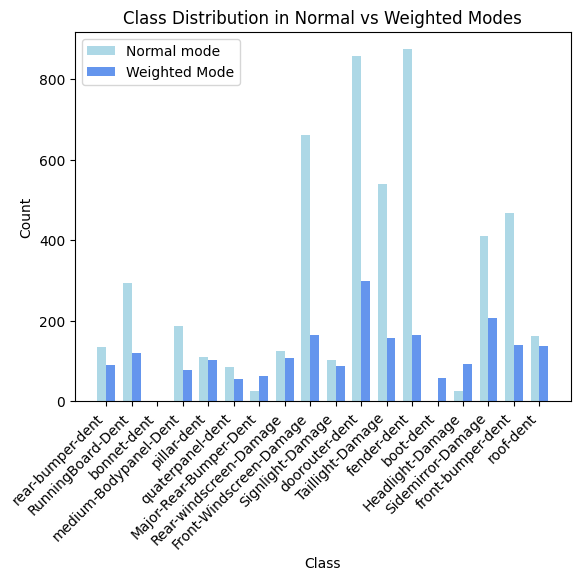

In [ ]:
# You can test different aggregation functions np.max, np.sum, np.median, np.mean
model.trainer.train_loader.dataset.agg_func = np.sum
model.trainer.train_loader.dataset.weights = model.trainer.train_loader.dataset.calculate_weights()
model.trainer.train_loader.dataset.probabilities = model.trainer.train_loader.dataset.calculate_probabilities()

# Verify class balance in training mode
model.trainer.train_loader.dataset.train_mode = True
train_counts = verify_class_balance(model.trainer.train_loader.dataset, num_samples=1000)

# Verify class balance in validation mode
model.trainer.train_loader.dataset.train_mode = False
val_counts = verify_class_balance(model.trainer.train_loader.dataset, num_samples=1000)

# Plot the comparison
plot_class_balance(train_counts, val_counts, set(model.trainer.train_loader.dataset.data["names"].values()))

# Monkey-patching for multi-GPU

In [ ]:

# Use callbacks to monkey-patch

def patch_dataset(trainer):
  from ultralytics.data.dataset import YOLODataset
  import ultralytics.data.build as build
  import numpy as np

  class YOLOWeightedDataset(YOLODataset):
      def __init__(self, *args, mode="train", **kwargs):
          """
          Initialize the WeightedDataset.

          Args:
              class_weights (list or numpy array): A list or array of weights corresponding to each class.
          """

          super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

          self.train_mode = "train" in self.prefix

          # You can also specify weights manually instead
          self.count_instances()
          class_weights = np.sum(self.counts) / self.counts
          self.agg_func = np.mean

          self.class_weights = np.array(class_weights)
          self.weights = self.calculate_weights()
          self.probabilities = self.calculate_probabilities()

      def count_instances(self):
          """
          Count the number of instances per class

          Returns:
              dict: A dict containing the counts for each class.
          """
          self.counts = [0 for i in range(len(self.data["names"]))]
          for label in self.labels:
              cls = label['cls'].reshape(-1).astype(int)
              for id in cls:
                  self.counts[id] += 1

          self.counts = np.array(self.counts)
          self.counts = np.where(self.counts == 0, 1, self.counts)

      def calculate_weights(self):
          """
          Calculate the aggregated weight for each label based on class weights.

          Returns:
              list: A list of aggregated weights corresponding to each label.
          """
          weights = []
          for label in self.labels:
              cls = label['cls'].reshape(-1).astype(int)

              # Give a default weight to background class
              if cls.size == 0:
                weights.append(1)
                continue

              # Take mean of weights
              # You can change this weight aggregation function to aggregate weights differently
              # weight = np.mean(self.class_weights[cls])
              # weight = np.max(self.class_weights[cls])
              weight = self.agg_func(self.class_weights[cls])
              weights.append(weight)
          return weights

      def calculate_probabilities(self):
          """
          Calculate and store the sampling probabilities based on the weights.

          Returns:
              list: A list of sampling probabilities corresponding to each label.
          """
          total_weight = sum(self.weights)
          probabilities = [w / total_weight for w in self.weights]
          return probabilities

      def __getitem__(self, index):
          """
          Return transformed label information based on the sampled index.
          """
          # Don't use for validation
          if not self.train_mode:
              return self.transforms(self.get_image_and_label(index))
          else:
              index = np.random.choice(len(self.labels), p=self.probabilities)
              return self.transforms(self.get_image_and_label(index))

       build.YOLODataset = YOLOWeightedDataset

In [ ]:
model = YOLO("yolo11n.pt")

In [ ]:
model.add_callback("on_pretrain_routine_start", patch_dataset)

In [ ]:
results = model.train(data="/content/drive/MyDrive/Car_Dent_Scratch_Detection-/data.yaml", epochs=50)